# Expectation-Maximization

In this assignment we will be using the Expectation Maximization method to estimate the parameters of the same three coin experiment as in the theoretical part. We will examine the behavior of the algorithm for various combinations of parameters.

## Description of the Experiment

The following procedure generates the data for the three coin experiment.

The parameters are:

- $\lambda$ := The probability of heads on the hidden coin H.

- $p_1$ := The probability of heads on coin A.

- $p_2$ := The probability of heads on coin B.

Each of the $N$ samples is collected the following way:

- The secret coin (H) is tossed.

- If the result is heads, coin A is tossed $M$ times and the results are recorded.

- If the result is tails, coin B is tossed $M$ times and the results are recorded.

**Heads are recorded as 1.** 

**Tails are recorded as 0.**

The data is returned as an **$N \times M$** matrix, where each of the $N$ rows correspond to the trials and contains the results of the corresponding sample (generated either by coin A or by coin B).

## Description of Provided Functions

Three functions are provided for your convenience:

*  **`utils.generateData(lambda,p1,p2,N,M)`:** Performs the experiment $N$ times with coin parameters specified as argument and returns the results in a $N \times M$ matrix.


* **`utils.unknownData()`** Returns a dataset of size $N \times M$ where generation parameters are unknown.


*  **`utils.plot(data,distribution)`:** Plot a histogram of the number of heads per trial along with the probability distribution. This function will be used to visualize the progress of the EM algorithm at every iteration.

An example of use of these two functions is given below:

[[1 1 1 1 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [1 1 1 1 1]
 [0 1 0 1 1]
 [1 0 1 0 0]
 [0 0 1 1 0]
 [0 0 0 0 0]
 [1 1 1 0 1]
 [0 1 1 0 1]
 [1 1 1 0 1]
 [1 1 1 1 1]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [1 1 1 1 1]]
(15, 5)


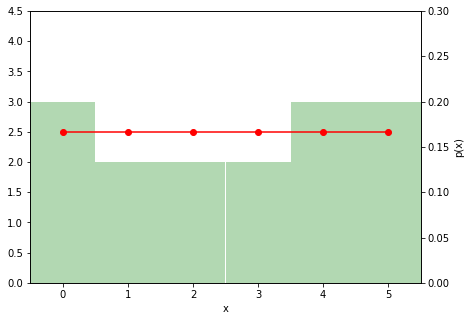

In [3]:
%matplotlib inline
import numpy,utils

# Print the data matrix as a result of the three coins experiment with parameter 0.5, 0.8 and 0.2.
data = utils.generateData(0.5,0.8,0.2,15,5)
# data = utils.unknownData()
print(data)
print(data.shape)

# Print the data histogram along with a uniform probability distribution.
utils.plot(data,numpy.ones([data.shape[1]+1])/(data.shape[1]+1))

In [4]:
numpy.ones([2,2])
h_x = data.sum(axis = 1)
t_x = numpy.ones([data.shape[1]],dtype = int)-data
t_x = t_x.sum(axis = 1)

A = numpy.log(4**h_x)
D = utils.unknownData()
print(D.shape)

(1000, 20)


## Calculate the Log-Likelihood (10 P)

Implement a function which calculates the log likelihood for a given dataset and parameters. The log-likelihood is given by:
$$
LL = \frac1N \sum_{i=1}^N \log \!\! \sum_{z \in \{\mathrm{heads},\mathrm{tails}\}} \!\! P(X=x_i, Z=z \mid \theta)\\
   = \frac1N \sum_{i=1}^N \log \left[ \lambda \cdot p_1^{h(x_i)} \cdot (1-p_1)^{t(x_i)} + (1-\lambda) \cdot p_2^{h(x_i)} \cdot (1-p_2)^{t(x_i)} \right]
$$
where $h(x_i)$ and $t(x_i)$ denote the number of heads and tails in sample $i$, respectively. Note that we take the averaged log-likelihood over all trials, hence the multiplicative term $\frac1N$ in front.

In [5]:
import scipy
import scipy.stats,scipy.io

def pdf(lam,p1,p2,M):
    x = lam*scipy.stats.binom.pmf(range(M+1),M,p1) +(1-lam)*scipy.stats.binom.pmf(range(M+1),M,p2) #两顶分布的pdf，取M+1个点，
    return x

def loglikelihood(data,lam,p1,p2):
    N,M = data.shape
    h = numpy.sum(data,axis = 1)
    p = pdf(lam,p1,p2,M)
    return numpy.mean(numpy.log(numpy.array([p[hh] for hh in h])))

In [10]:
def loglikelihood(data,lam,p1,p2):
    h_x = data.sum(axis = 1)
    t_x = numpy.ones([data.shape[1]],dtype = int) - data
    t_x = t_x.sum(axis = 1)
    
    LL_log = numpy.log((lam*p1**h_x)*(1-p1)**t_x + (1-lam)*p2**h_x*(1-p2)**t_x)
    LL = (1/data.shape[0])*numpy.sum(LL_log)
    
    return LL

In [6]:
Data = utils.unknownData()
a = loglikelihood(Data,0.5,0.25,0.75)
print(a)

-3.035229931100662


## Implementing and Running the EM Algorithm (30 P)

Implement a function which iteratively determines the values of $\lambda$, $p_1$ and $p_2$. The function starts with some initial estimates for the parameters and returns the results of the method for those parameters.

In each iteration, the following update rules are used for the parameters:

$$\lambda^{new} = \frac{E(\#heads(coin\_H))}{\#throws(coin\_H)} = \frac{1}{N}\sum_{i=1}^{N}\frac{\lambda p_1^{h(x_i)}(1-p_1)^{t(x_i)}}{\lambda p_1^{h(x_i)}(1-p_1)^{t(x_i)} + (1-\lambda)p_2^{h(x_i)}(1-p_2)^{t(x_i)}}$$

$$p_1^{new} = \frac{E(\#heads(coin\_A))}{E(\#throws(coin\_A))} = \frac{\sum_{i=1}^{N}R_1(i)h(x_i)}{M \sum_{i=1}^{N}R_1(i)}$$

$$p_2^{new} = \frac{E(\#heads(coin\_B))}{E(\#throws(coin\_B))} = \frac{\sum_{i=1}^{N}R_2(i)h(x_i)}{M \sum_{i=1}^{N}R_2(i)}$$

where $h(x_i)$ and $t(x_i)$ denote the number of heads and tails in sample i, respectively, and

$$R_1(i) = \frac{\lambda p_1^{h(x_i)}(1-p_1)^{t(x_i)}}{\lambda p_1^{h(x_i)}(1-p_1)^{t(x_i)} + (1-\lambda)p_2^{h(x_i)}(1-p_2)^{t(x_i)}}$$

$$R_2(i) = \frac{(1-\lambda) p_2^{h(x_i)}(1-p_2)^{t(x_i)}}{\lambda p_1^{h(x_i)}(1-p_1)^{t(x_i)} + (1-\lambda)p_2^{h(x_i)}(1-p_2)^{t(x_i)}}$$


**TODO:**

* **Implement the EM learning procedure.**
* **Use as stopping criterion the improvement of log-likelihood between two iterations to be smaller than $0.001$.**
* **Run the EM procedure on the data returned by function `utils.unknownData()`. Use as an initial solution for your model the parameters $\lambda = 0.5$, $p_1 = 0.25$, $p_2 = 0.75$ **.
* **At each iteration of the EM procedure, print the log-likelihood and the value of your model parameters, and plot the learned probability distribution using the function utils.plot().**

In [7]:
loglikelihood(data,0.5,0.8,0.2)

-1.794754610906787

In [ ]:
import utils
%matplotlib inline
# -------------------------------------------
# Template for your code
# -------------------------------------------
#TODO: Initialize the model
data = utils.unknownData()
lam = 0.5
p1 = 0.25
p2 = 0.75

N,M = data.shape
pz = numpy.zeros([2,N])
criterion = False
it = 0
while(criterion == False):
    it += 1
    N,M = data.shape
    
    utils.plot(data,pdf(lam,p1,p2,M))
    heads = numpy.sum(data,axis = 1)
    tails = M-heads
    
    likelihood = loglikelihood(data,lam,p1,p2)
    
    
    pz[0,:] = lam*p1**heads*(1-p1)**tails
    pz[1,:] = (1-lam)*p2**heads*(1-p2)**tails
    pz = pz/pz.sum(axis = 0)
    
    lam = numpy.sum(pz[0,:],axis = 0)/N
    p1 = numpy.sum(heads*pz[0,:])/(M*numpy.sum(pz[0,:])+1e-9)
    p2 = numpy.sum(heads*pz[1,:])/(M*numpy.sum(pz[1,:])+1e-9)
    
    likelihood_new = loglikelihood(data,lam,p1,p2)
    diff = abs(likelihood - likelihood_new)
    # - Print the log-likelihood and the model parameters
    print('it:%2d'%it + '  lambda:%.2f'%lam + '  p1:%.2f'%p1 + '  p2:%.2f'%p2 + '  log-likelihood:%.3f'%likelihood)
    if diff< 0.001: criterion == True

it: 1  lambda:0.15  p1:0.41  p2:0.76  log-likelihood:-3.035
it: 2  lambda:0.18  p1:0.44  p2:0.77  log-likelihood:-2.543
it: 3  lambda:0.21  p1:0.46  p2:0.78  log-likelihood:-2.518
it: 4  lambda:0.23  p1:0.47  p2:0.78  log-likelihood:-2.506
it: 5  lambda:0.24  p1:0.48  p2:0.78  log-likelihood:-2.500
it: 6  lambda:0.25  p1:0.48  p2:0.79  log-likelihood:-2.498
it: 7  lambda:0.26  p1:0.48  p2:0.79  log-likelihood:-2.496
it: 8  lambda:0.26  p1:0.49  p2:0.79  log-likelihood:-2.496
it: 9  lambda:0.27  p1:0.49  p2:0.79  log-likelihood:-2.496
it:10  lambda:0.27  p1:0.49  p2:0.79  log-likelihood:-2.495
it:11  lambda:0.27  p1:0.49  p2:0.79  log-likelihood:-2.495
it:12  lambda:0.27  p1:0.49  p2:0.79  log-likelihood:-2.495
it:13  lambda:0.27  p1:0.49  p2:0.79  log-likelihood:-2.495
it:14  lambda:0.27  p1:0.49  p2:0.79  log-likelihood:-2.495
it:15  lambda:0.27  p1:0.49  p2:0.79  log-likelihood:-2.495
it:16  lambda:0.27  p1:0.49  p2:0.79  log-likelihood:-2.495
it:17  lambda:0.28  p1:0.49  p2:0.79  lo

C:\Users\htlsh\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


it:23  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:24  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:25  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:26  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:27  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:28  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:29  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:30  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:31  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:32  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:33  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:34  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:35  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:36  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:37  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:38  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:39  lambda:0.28  p1:0.49  p2:0.79  lo

it:161  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:162  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:163  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:164  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:165  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:166  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:167  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:168  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:169  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:170  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:171  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:172  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:173  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:174  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:175  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:176  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:177  lambda:0.28  p1:

it:297  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:298  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:299  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:300  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:301  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:302  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:303  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:304  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:305  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:306  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:307  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:308  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:309  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:310  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:311  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:312  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:313  lambda:0.28  p1:

it:435  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:436  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:437  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:438  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:439  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:440  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:441  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:442  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:443  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:444  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:445  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:446  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:447  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:448  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:449  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:450  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:451  lambda:0.28  p1:

it:570  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:571  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:572  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:573  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:574  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:575  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:576  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:577  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:578  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:579  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:580  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:581  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:582  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:583  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:584  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:585  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:586  lambda:0.28  p1:

it:706  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:707  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:708  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:709  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:710  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:711  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:712  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:713  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:714  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:715  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:716  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:717  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:718  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:719  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:720  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:721  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:722  lambda:0.28  p1:

it:844  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:845  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:846  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:847  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:848  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:849  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:850  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:851  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:852  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:853  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:854  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:855  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:856  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:857  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:858  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:859  lambda:0.28  p1:0.49  p2:0.79  log-likelihood:-2.495
it:860  lambda:0.28  p1:

In [11]:
def gaussian(x,mu,sig):
    return numpy.exp(-(x-mu)**2/(2*sig**2))

def distribution(data,lam,p1,p2):
    dis = numpy.zeros([data.shape[1]+1])
    for i in range(len(dis)):
        pos = float(i/len(dis))
        dis[i] = lam*gaussian(pos,p1,0.1)+(1-lam)*gaussian(pos,p2,0.1)
    return dis/numpy.sum(dis)

def Distribution(data,lam,p1,p2):
    x= numpy.linspace(0,1, data.shape[1]+1)
    sig=0.1
    #disp1= matplotlib.mlab.normpdf(x, p1, sig)
    #disp2= matplotlib.mlab.normpdf(x, p2, sig)
    disp1 = numpy.exp(-(x - p1)**2/(2*sig**2))
    disp2 = numpy.exp(-(x - p2)**2/(2*sig**2))
    
    distribution = lam * disp1 + (1-lam) * disp2
    distribution=distribution/ distribution.sum()
    return  distribution

it: 1  lambda:0.15  p1:0.41  p2:0.76  log-likelihood:-11.709
it: 2  lambda:0.18  p1:0.44  p2:0.77  log-likelihood:-11.684
it: 3  lambda:0.21  p1:0.46  p2:0.78  log-likelihood:-11.672
it: 4  lambda:0.23  p1:0.47  p2:0.78  log-likelihood:-11.666
it: 5  lambda:0.24  p1:0.48  p2:0.78  log-likelihood:-11.664
it: 6  lambda:0.25  p1:0.48  p2:0.79  log-likelihood:-11.662
it: 7  lambda:0.26  p1:0.48  p2:0.79  log-likelihood:-11.662


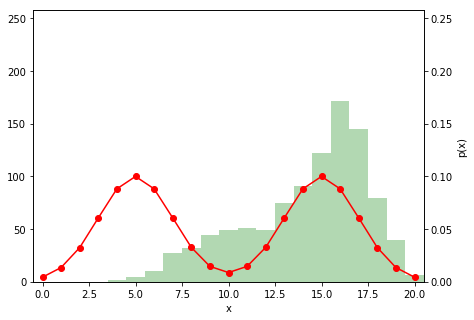

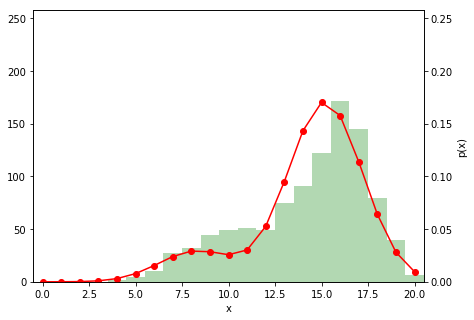

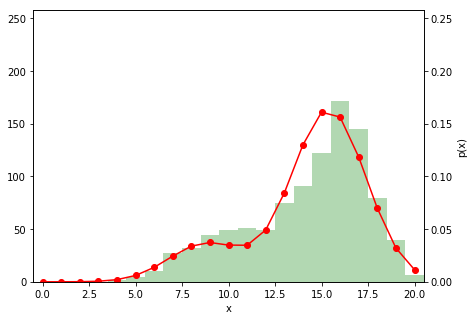

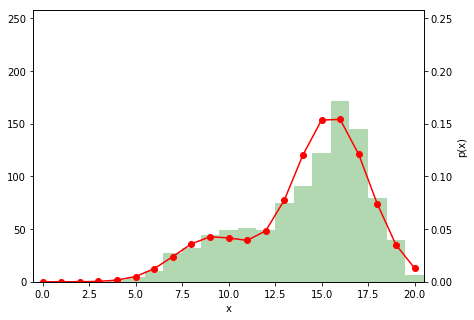

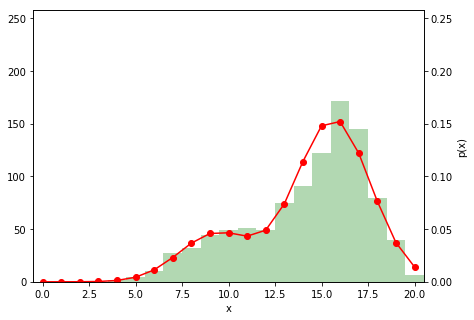

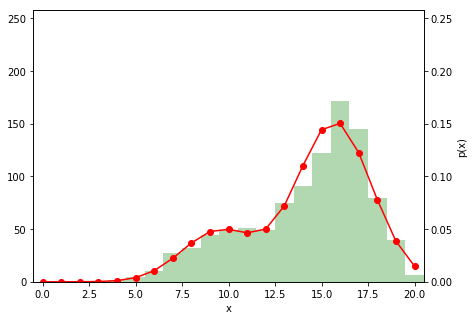

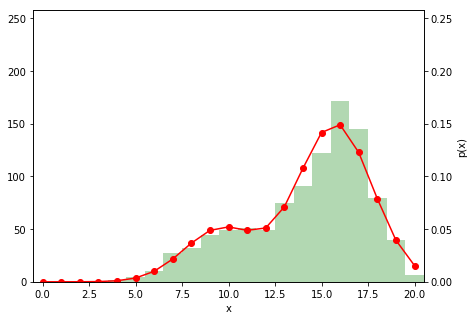

In [6]:
import utils
%matplotlib inline
# -------------------------------------------
# Template for your code
# -------------------------------------------
#TODO: Initialize the model
lam = 0.5
p1  = 0.25
p2  = 0.75

criterion = False # (to be set to True)
data = utils.unknownData()
h_x = data.sum(axis = 1)
t_x = numpy.ones([data.shape[1]],dtype = int) - data
t_x = t_x.sum(axis = 1)
# Iterate until the stopping criterion is satisfied
it = 0
while(criterion == False):
    # - Perform one step of EM
    LL_old = loglikelihood(data,lam,p1,p2)
    R1 = ((lam*p1**h_x)*(1-p1)**t_x)/(lam*p1**h_x*(1-p1)**t_x + (1-lam)*p2**h_x*(1-p2)**t_x)
    R2 = (((1-lam)*p2**h_x)*(1-p2)**t_x)/(lam*p1**h_x*(1-p1)**t_x + (1-lam)*p2**h_x*(1-p2)**t_x)
    lam_new = (1/data.shape[0])*numpy.sum(R1)
    p1_new = (1/data.shape[1])*(numpy.sum(R1*h_x))/(numpy.sum(R1))
    p2_new = (1/data.shape[1])*(numpy.sum(R2*h_x))/(numpy.sum(R2))
    
    # - Plot data histogram and the learned probability distribution
    utils.plot(data,Distribution(data,lam,p1,p2))
    
    LL = loglikelihood(data,lam_new,p1_new,p2_new)
    lam = lam_new
    p1 = p1_new
    p2 = p2_new
    it += 1
    # - Print the log-likelihood and the model parameters
    print('it:%2d'%it + '  lambda:%.2f'%lam + '  p1:%.2f'%p1 + '  p2:%.2f'%p2 + '  log-likelihood:%.3f'%LL)
    
    # - Determine if stopping criterion is satisfied
    criterion = abs(LL - LL_old)<0.001
   

## More Experiments (10 P)

Examine the behaviour of the EM algorithm for various combinations of data generation parameters and initializations (for generating various distributions, use the method `utils.generateData(...)`). In particular, find settings for which:

* The role of coins $A$ and $B$ are permuted between the data generating model and the learned model (i.e. $\hat p_1 \approx p_2$, $\hat p_2 \approx p_1$ and $\hat \lambda \approx 1-\lambda$).

* The EM procedure takes a long time to converge.

Print the parameters and log-likelihood objective at each iteration. Only display the plot for the converged model.

In [50]:
def iteration(data):
    #Initialize the model
    lam = 0.5
    p1  = 0.25
    p2  = 0.75

    criterion = False # (to be set to True)
    h_x = data.sum(axis = 1)
    t_x = numpy.ones([data.shape[1]],dtype = int) - data
    t_x = t_x.sum(axis = 1)
    #Iterate until the stopping criterion is satisfied
    it = 0
    while(criterion == False):
        # - Perform one step of EM
        LL_old = loglikelihood(data,lam,p1,p2)
        R1 = ((lam*p1**h_x)*(1-p1)**t_x)/(lam*p1**h_x*(1-p1)**t_x + (1-lam)*p2**h_x*(1-p2)**t_x)
        R2 = (((1-lam)*p2**h_x)*(1-p2)**t_x)/(lam*p1**h_x*(1-p1)**t_x + (1-lam)*p2**h_x*(1-p2)**t_x)
        lam_new = (1/data.shape[0])*numpy.sum(R1)
        p1_new = (1/data.shape[1])*(numpy.sum(R1*h_x))/(numpy.sum(R1))
        p2_new = (1/data.shape[1])*(numpy.sum(R2*h_x))/(numpy.sum(R2))
    
        LL = loglikelihood(data,lam_new,p1_new,p2_new)
        lam = 1-lam_new
        p1 = p2_new
        p2 = p1_new
        it += 1
    
        # - Determine if stopping criterion is satisfied
        criterion = abs(LL - LL_old)<0.001
    return[LL,lam,p1,p2,it]

In [53]:
x = numpy.linspace(0,1,10)
x = numpy.around(x,decimals = 2)

for lam in x:
    for p1 in x:
        for p2 in x:
            data = utils.generateData(lam,p1,p2,1000,20)
            [LL_per,lam_per,p1_per,p2_per,it_per] = iteration(data)
            if ((abs((1-lam_per)-lam)<0.1) and (abs(p1 - p2_per)<0.1) and (abs(p2 - p1_per)<0.1)) and it_per>20:
                print('it:%2d lambda: %.2f  p1: %.2f  p2: %.2f  log-likelihood: %.3f lamda_hat:%.2f p1_hat%.2f p2_hat%.2f'%\
                      (it_per,lam, p1, p2, LL_per,lam_per,p1_per,p2_per))

it:29 lambda: 0.11  p1: 0.11  p2: 0.44  log-likelihood: -13.289 lamda_hat:0.88 p1_hat0.44 p2_hat0.13
it:26 lambda: 0.11  p1: 0.89  p2: 0.56  log-likelihood: -13.264 lamda_hat:0.88 p1_hat0.56 p2_hat0.88
it:50 lambda: 0.11  p1: 1.00  p2: 0.78  log-likelihood: -9.534 lamda_hat:0.86 p1_hat0.78 p2_hat1.00
it:23 lambda: 0.33  p1: 0.11  p2: 0.33  log-likelihood: -11.119 lamda_hat:0.60 p1_hat0.34 p2_hat0.13
it:24 lambda: 0.33  p1: 0.89  p2: 0.67  log-likelihood: -11.073 lamda_hat:0.60 p1_hat0.66 p2_hat0.87
it:26 lambda: 0.56  p1: 0.11  p2: 0.00  log-likelihood: -4.473 lamda_hat:0.53 p1_hat0.01 p2_hat0.12
it:24 lambda: 0.67  p1: 0.33  p2: 0.11  log-likelihood: -11.138 lamda_hat:0.38 p1_hat0.12 p2_hat0.34
it:25 lambda: 0.67  p1: 0.56  p2: 0.78  log-likelihood: -13.020 lamda_hat:0.40 p1_hat0.75 p2_hat0.55
it:28 lambda: 0.78  p1: 0.22  p2: 0.00  log-likelihood: -8.804 lamda_hat:0.23 p1_hat0.00 p2_hat0.22
it:38 lambda: 0.78  p1: 0.33  p2: 0.11  log-likelihood: -11.722 lamda_hat:0.32 p1_hat0.15 p2_h

it: 1  lambda:0.73  p1:0.35  p2:0.56  log-likelihood:-13.490
it: 2  lambda:0.71  p1:0.36  p2:0.53  log-likelihood:-13.473
it: 3  lambda:0.69  p1:0.36  p2:0.52  log-likelihood:-13.468
it: 4  lambda:0.67  p1:0.36  p2:0.51  log-likelihood:-13.465
it: 5  lambda:0.64  p1:0.35  p2:0.51  log-likelihood:-13.461
it: 6  lambda:0.62  p1:0.35  p2:0.50  log-likelihood:-13.457
it: 7  lambda:0.59  p1:0.34  p2:0.50  log-likelihood:-13.453
it: 8  lambda:0.57  p1:0.34  p2:0.50  log-likelihood:-13.448
it: 9  lambda:0.54  p1:0.33  p2:0.50  log-likelihood:-13.443
it:10  lambda:0.51  p1:0.33  p2:0.49  log-likelihood:-13.437
it:11  lambda:0.48  p1:0.32  p2:0.49  log-likelihood:-13.431
it:12  lambda:0.45  p1:0.31  p2:0.49  log-likelihood:-13.424
it:13  lambda:0.42  p1:0.30  p2:0.48  log-likelihood:-13.416
it:14  lambda:0.38  p1:0.29  p2:0.48  log-likelihood:-13.407
it:15  lambda:0.35  p1:0.28  p2:0.48  log-likelihood:-13.396
it:16  lambda:0.32  p1:0.27  p2:0.47  log-likelihood:-13.385
it:17  lambda:0.28  p1:0

C:\Users\htlsh\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


it:23  lambda:0.13  p1:0.14  p2:0.45  log-likelihood:-13.298
it:24  lambda:0.12  p1:0.13  p2:0.45  log-likelihood:-13.295
it:25  lambda:0.12  p1:0.12  p2:0.45  log-likelihood:-13.294
it:26  lambda:0.11  p1:0.12  p2:0.44  log-likelihood:-13.294


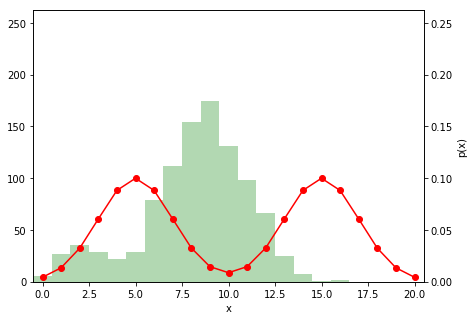

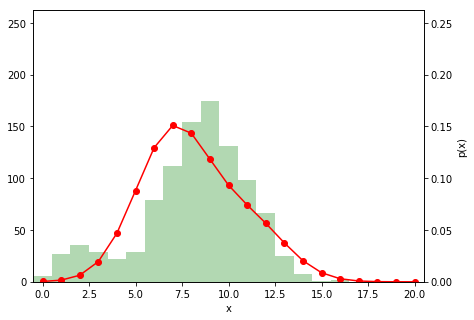

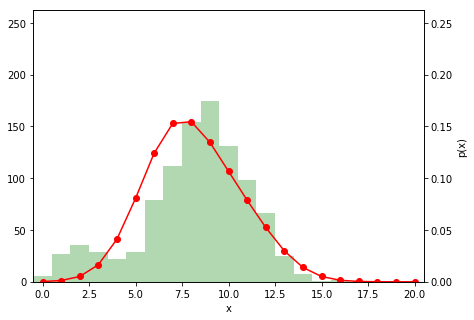

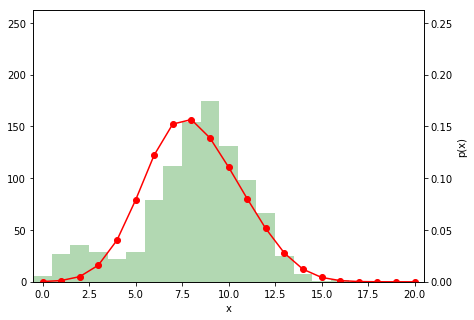

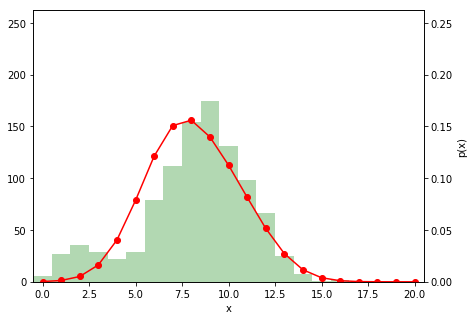

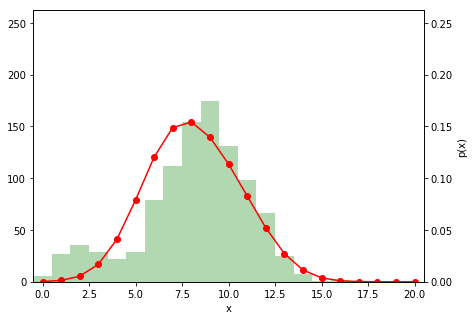

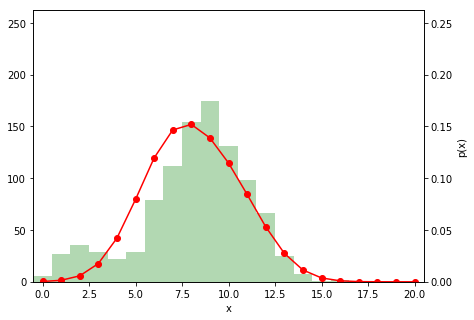

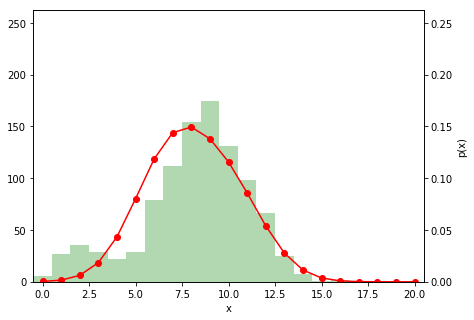

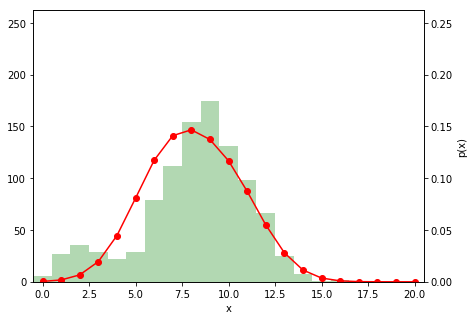

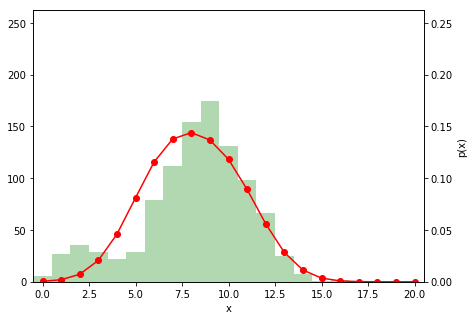

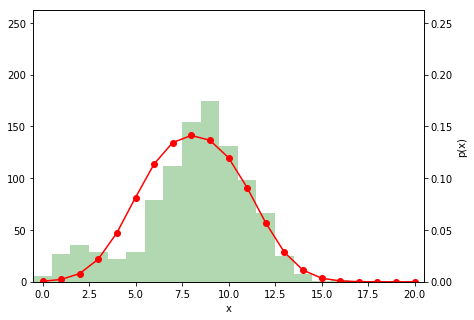

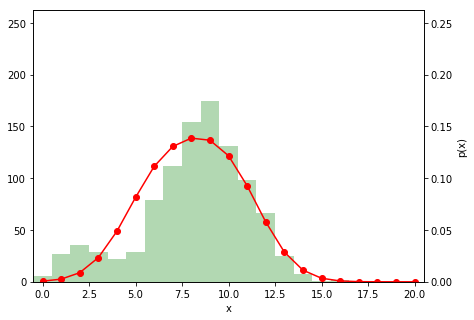

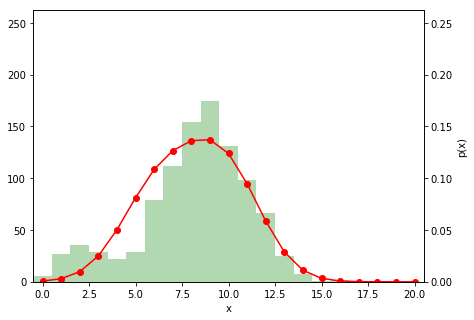

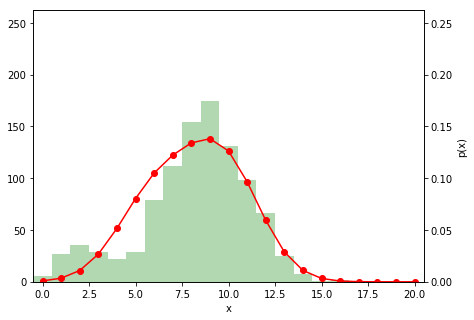

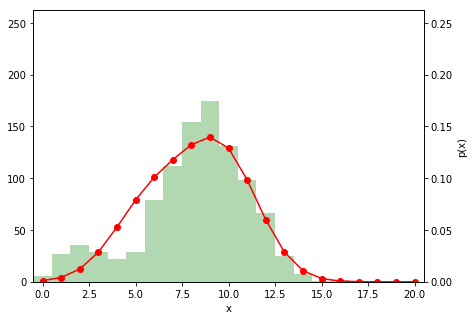

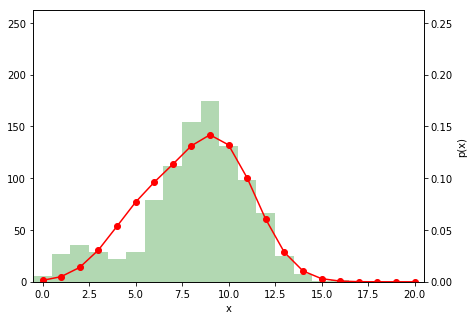

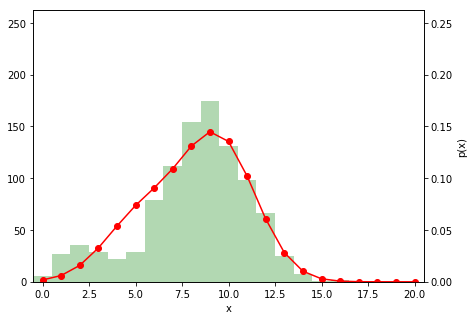

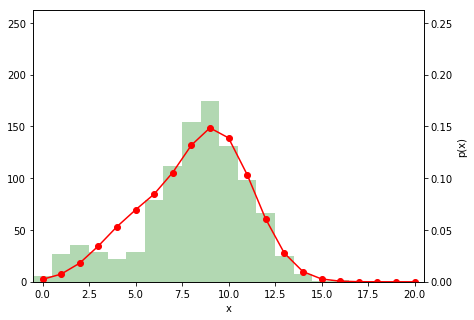

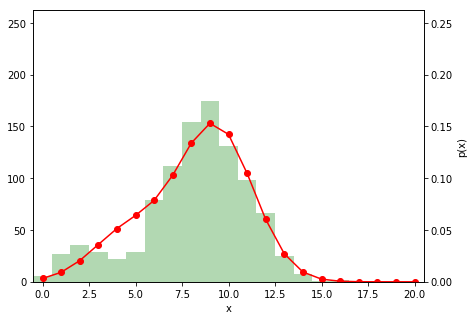

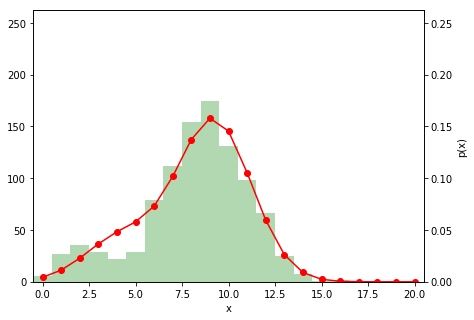

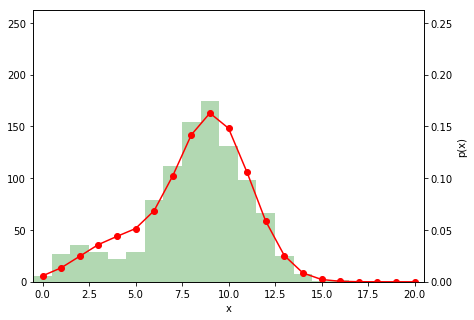

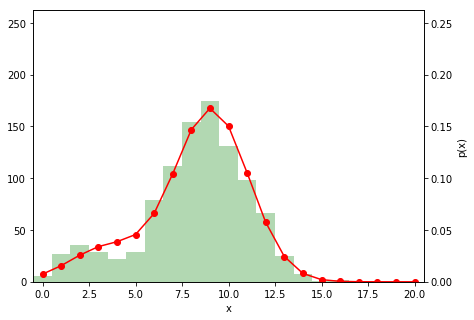

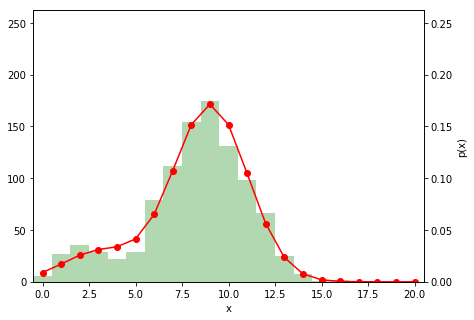

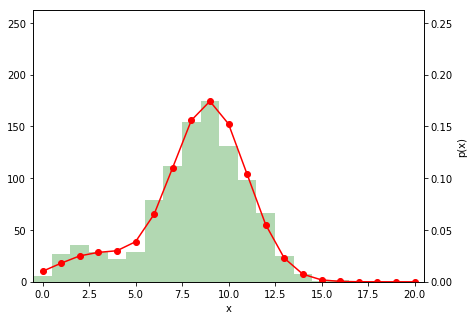

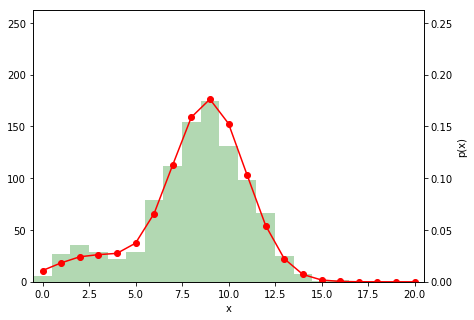

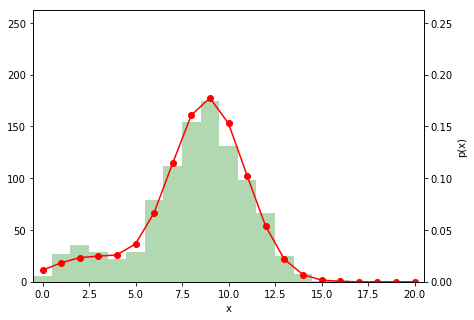

In [54]:
#TODO: Initialize the model
lam = 0.5
p1  = 0.25
p2  = 0.75

criterion = False # (to be set to True)
data = utils.generateData(0.89,0.44,0.11,1000,20)
h_x = data.sum(axis = 1)
t_x = numpy.ones([data.shape[1]],dtype = int) - data
t_x = t_x.sum(axis = 1)
# Iterate until the stopping criterion is satisfied
it = 0
while(criterion == False):
    # - Perform one step of EM
    LL_old = loglikelihood(data,lam,p1,p2)
    R1 = ((lam*p1**h_x)*(1-p1)**t_x)/(lam*p1**h_x*(1-p1)**t_x + (1-lam)*p2**h_x*(1-p2)**t_x)
    R2 = (((1-lam)*p2**h_x)*(1-p2)**t_x)/(lam*p1**h_x*(1-p1)**t_x + (1-lam)*p2**h_x*(1-p2)**t_x)
    lam_new = (1/data.shape[0])*numpy.sum(R1)
    p1_new = (1/data.shape[1])*(numpy.sum(R1*h_x))/(numpy.sum(R1))
    p2_new = (1/data.shape[1])*(numpy.sum(R2*h_x))/(numpy.sum(R2))
    
    # - Plot data histogram and the learned probability distribution
    utils.plot(data,Distribution(data,lam,p1,p2))
    
    LL = loglikelihood(data,lam_new,p1_new,p2_new)
    lam = lam_new
    p1 = p1_new
    p2 = p2_new
    it += 1
    # - Print the log-likelihood and the model parameters
    print('it:%2d'%it + '  lambda:%.2f'%lam + '  p1:%.2f'%p1 + '  p2:%.2f'%p2 + '  log-likelihood:%.3f'%LL)
    
    # - Determine if stopping criterion is satisfied
    criterion = abs(LL - LL_old)<0.001